In [1]:
import numpy as np
import matplotlib.pylab as plt
from functions import *
import sys, os
sys.path.append(os.pardir)
from collections import OrderedDict

In [2]:
class Relu:
    def __init__(self):
        self.mask = None
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self, dout):
        dout[self.mask] = 0
        return dout
class Sigmoid:
    def __init__(self):
        self.out = None
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out
    def backward(self, dout):
        return dout * (1.0 - self.out) * self.out
class Affine:
    def __init__(self, W, b):
        self.W  = W
        self.b  = b
        self.x  = self.dW = self.db = None
    def forward(self, x):
        self.x = x
        return np.dot(x, self.W) + self.b
    def backward(self, dout):
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return np.dot(dout, self.W.T)
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = self.y = self.t = None
    def forward(self, x, t):
        self.t    = t
        self.y    = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            return (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            return dx / batch_size
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask          = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

In [3]:
class MultiLayerNet:
    def __init__(self, input_size, hidden_size_list, output_size, weight_init_std=0.01, weight_decay_lambda=0.1, dropout_ration = 0.5):
        self.layer_num  = len(hidden_size_list)
        layer_size_list = [input_size] + hidden_size_list + [output_size]
        self.params = {}
        for idx in range(1, self.layer_num +2):
            self.params['W' + str(idx)] = weight_init_std * np.random.randn(layer_size_list[idx-1], layer_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(layer_size_list[idx])
        self.layers = OrderedDict()
        for i in range(1, self.layer_num + 1):
            si                         = str(i)
            self.layers['Affine'  + si] = Affine(self.params['W' + si], self.params['b' + si])
            self.layers['Relu'    + si] = Relu()
            if dropout_ration != 0:
                self.layers['Dropout' + si] = Dropout(dropout_ration)
        self.lastLayer           = SoftmaxWithLoss()
        self.weight_decay_lambda = weight_decay_lambda
    # 推定
    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x
    # 損失算出
    def loss(self, x, t, train_flg=False):
        y = self.predict(x, train_flg)
        L2_norm = np.sqrt(sum([0.5 * self.weight_decay_lambda * np.sum(self.params['W' + str(idx)] ** 2) for idx in range(1, self.layer_num+1)]))
        return self.lastLayer.forward(y, t) + L2_norm
    # accuracy算出
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    # 解析的微分（誤差逆伝播）
    def gradient(self, x, t):
        # 順伝播
        self.loss(x, t, train_flg=True)
        # 逆伝播
        dout   = 1
        dout   = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        # 勾配
        grads       = {}
        for i in range(1, self.layer_num + 1):
            si = str(i)
            self.params['W' + si] -= learning_rate * self.layers['Affine' + si].dW
            self.params['b' + si] -= learning_rate * self.layers['Affine' + si].db
            self.layers['Affine' + si] = Affine(self.params['W' + si], self.params['b' + si])
            self.layers['Relu'   + si] = Relu()
        return 0

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


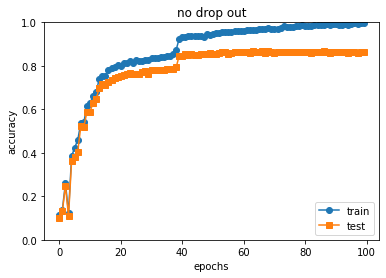

In [4]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from mnist import load_mnist
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 過学習を再現するために、学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]
network         = MultiLayerNet(input_size=784, hidden_size_list=[50, 50], output_size=10, weight_init_std=0.01, weight_decay_lambda=0.2, dropout_ration=0)
train_size      = x_train.shape[0]
batch_size      = 100
epoch           = 100
learning_rate   = 0.1
train_loss_list = []
iter_per_epoch  = max(train_size / batch_size, 1)
iters_num       = int(train_size / batch_size * epoch)
train_acc_list  = np.zeros(epoch)
test_acc_list   = np.zeros(epoch)
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    network.gradient(x_batch, t_batch)
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list[int(i // iter_per_epoch)] = train_acc
        test_acc_list[int(i // iter_per_epoch)]  = test_acc
x = np.arange(epoch)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=1)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=1)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("no drop out")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

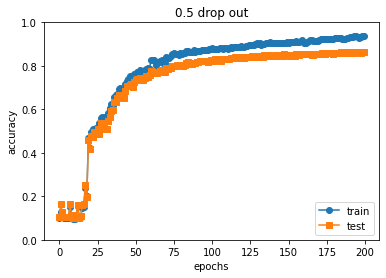

In [5]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from mnist import load_mnist
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 過学習を再現するために、学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]
network         = MultiLayerNet(input_size=784, hidden_size_list=[50, 50], output_size=10, weight_init_std=0.01, weight_decay_lambda=0.2, dropout_ration=0.5)
train_size      = x_train.shape[0]
batch_size      = 100
epoch           = 200
learning_rate   = 0.1
train_loss_list = []
iter_per_epoch  = max(train_size / batch_size, 1)
iters_num       = int(train_size / batch_size * epoch)
train_acc_list  = np.zeros(epoch)
test_acc_list   = np.zeros(epoch)
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    network.gradient(x_batch, t_batch)
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list[int(i // iter_per_epoch)] = train_acc
        test_acc_list[int(i // iter_per_epoch)]  = test_acc
x = np.arange(epoch)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=1)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=1)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("0.5 drop out")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

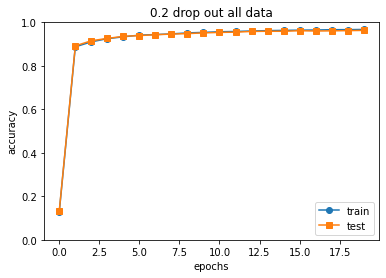

In [8]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from mnist import load_mnist
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 過学習を再現するために、学習データを削減
x_train = x_train
t_train = t_train
network         = MultiLayerNet(input_size=784, hidden_size_list=[50, 50], output_size=10, weight_init_std=0.01, weight_decay_lambda=0.2, dropout_ration=0.2)
train_size      = x_train.shape[0]
batch_size      = 100
epoch           = 20
learning_rate   = 0.1
train_loss_list = []
iter_per_epoch  = max(train_size / batch_size, 1)
iters_num       = int(train_size / batch_size * epoch)
train_acc_list  = np.zeros(epoch)
test_acc_list   = np.zeros(epoch)
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    network.gradient(x_batch, t_batch)
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list[int(i // iter_per_epoch)] = train_acc
        test_acc_list[int(i // iter_per_epoch)]  = test_acc
x = np.arange(epoch)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=1)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=1)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("0.2 drop out all data")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [10]:
print(test_acc_list[-1])

0.963
